In [1]:
# unset PYTHONPATH first
from ko_text import *
from ko_crawler import *

import ast

In [2]:
nlp = NLP()

# 불러오기

In [3]:
token_df = pd.read_csv('Data/meta_morphs_final.csv', encoding = 'utf-8')

# 용량을 줄이기 위해 '단어 단어' 꼴로 묶어둔 token을 ['단어', '단어'] 꼴로 풀기
token_df['Token'] = [token.split() for token in token_df['Token']]

In [4]:
token_df.head()

,Section,Text,Token,Num of Tokens
0,financial,\n\n\n텀블벅에서 크라우드 펀딩이 이뤄지고 있는 `아침달 시집`.\n\n ...,"[텀블벅, 크라, 우드, 펀딩, 이뤄지고, 아침, 시집, 많지, 않은, 금액, 으로...",263
1,economy,\n\n\n[사진 제공: 연합뉴스]\n\n 유류...,"[유류, 인하, 국제, 유가, 급락, 입어, 국내, 휘발유, 경유, 하락, 특히, ...",166
2,financial,부득이한 사정으로 매월 내는 보험료가 부담이 될 때 계약은 그대로 유지하면서 보험...,"[부득이, 사정, 매월, 내는, 보험료, 부담, 계약, 그대로, 유지, 보험료, 부...",314
3,estate,한때 `미분양의 늪`으로 통하던 경기도 파주시 부동산 시장이 달라지고 있다. 지난해...,"[한때, 미분, 하던, 경기도, 파주시, 부동산, 시장, 달라지고, 분양, 파주, ...",165
4,economy,\n\n\n인디고뱅크의 `미키인서울` 컬래버 맨투맨 <사진제공=월트디즈니코리아>\...,"[인디고, 뱅크, 미키, 서울, 컬래버, 투맨, 월트디즈니, 사의, 마스코트, 미키...",196


In [5]:
token_df.shape

(41418, 4)

# Train Test Split

In [6]:
train_size = round(len(token_df) * 0.8)

np.random.seed(0)
train_index_ls = np.random.choice(token_df.index, train_size, replace = False)
test_index_ls = [x for x in token_df.index if not x in train_index_ls]

In [7]:
train_df = token_df.loc[train_index_ls]
train_df.shape

(33134, 4)

In [8]:
train_df.head()

,Section,Text,Token,Num of Tokens
25537,stock,02일 항공/저가 항공사(LCC) 테마가 전일 대비 3.01% 상승하면서 강세를 보...,"[항공, 저가, 항공사, 테마, 전일, 대비, 상승, 강세, 보이는, 가운데, 주로...",200
14604,world,영국 극우정당 지도자가 반이슬람 활동으로 유명한 극우단체 지도자를 개인 고문으로 ...,"[영국, 극우, 정당, 지도자, 이슬람, 활동, 유명한, 극우, 단체, 지도자, 개...",204
20296,estate,"단장·산외면 일원 91만㎡에 3천억 투자…""밀양 르네상스 이끈다""\n경남 밀양에 농...","[단장, 산외면, 일원, 투자, 밀양, 르네상스, 이끈다, 경남, 밀양, 농촌, 테...",352
34830,business,아시아 각국 창업 생태계 현황을 한눈에 파악할 수 있는 행사가 열린다.\n스타트업 ...,"[아시아, 각국, 창업, 생태계, 현황, 한눈, 파악, 행사, 린다, 스타트업, 인...",128
6643,business,\n\n\n스파오 강남점 [사진제공 = 이랜드월드]\n\n ...,"[스파오, 강남, 이랜드, 월드, 전개, SPA, 브랜드, 스파오, 출시, 해리포터...",136


In [9]:
test_df = token_df.loc[test_index_ls]
test_df.shape

(8284, 4)

In [10]:
Counter(train_df['Section'])

Counter({'bio & tech': 1739,
         'business': 4863,
         'culture & art': 4102,
         'economy': 2608,
         'estate': 3932,
         'financial': 746,
         'it': 1742,
         'politics': 3775,
         'society': 3356,
         'stock': 2508,
         'world': 3763})

In [11]:
Counter(test_df['Section'])

Counter({'bio & tech': 419,
         'business': 1220,
         'culture & art': 1039,
         'economy': 613,
         'estate': 977,
         'financial': 181,
         'it': 419,
         'politics': 903,
         'society': 873,
         'stock': 665,
         'world': 975})

# sampling for training classfier

In [12]:
# 한 label마다 학습할 단어의 수
train_batch_size = 1000
test_batch_size = 100

train_token_ls_split, train_tag_ls_split = nlp.oversample_batch(train_df['Token'], train_df['Section'], train_batch_size)
test_token_ls_split, test_tag_ls_split =  nlp.undersample_batch(test_df['Token'],test_df['Section'], test_batch_size)

In [13]:
print(len(train_token_ls_split))
Counter(train_tag_ls_split)

11000


Counter({'bio & tech': 1000,
         'business': 1000,
         'culture & art': 1000,
         'economy': 1000,
         'estate': 1000,
         'financial': 1000,
         'it': 1000,
         'politics': 1000,
         'society': 1000,
         'stock': 1000,
         'world': 1000})

<br>


# **Doc2Vec**

## **1. DM, DBOW 모델 불러오기**

In [14]:
dm = NLP()
dbow = NLP()

# 가장 성능이 좋았던 모델들 호출
dm.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=True&cc=42331&vs=100&win=5&min=1&sample=1e-06&epochs=10')
dbow.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=False&cc=41418&vs=100&win=5&min=1&sample=1e-06&epochs=10')

## **2. Doc2Vec으로 벡터 추정 분포 확인**

In [15]:
test_token_for_display_dm, test_tag_for_display_dm = dm.undersample_batch(test_df['Token'], test_df['Section'], 300)
test_token_for_display_dbow, test_tag_for_display_dbow = dbow.undersample_batch(test_df['Token'], test_df['Section'], 300)

In [16]:
Counter(test_tag_for_display_dm)

Counter({'bio & tech': 181,
         'business': 181,
         'culture & art': 181,
         'economy': 181,
         'estate': 181,
         'financial': 181,
         'it': 181,
         'politics': 181,
         'society': 181,
         'stock': 181,
         'world': 181})

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## tsne

## DM

In [ ]:
X =dm.infer_vectors_with_Doc2Vec(test_token_for_display_dm, alpha = 0.1)

tsne= TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
scatter_df = pd.DataFrame(X_tsne,
                          index = test_tag_for_display_dm,
                          columns = ['x','y'])

plt.figure(figsize = (10, 10))

for i,section in enumerate(set(test_df['Section'])):
    temp_df = scatter_df[scatter_df.index == section]
    plt.scatter(temp_df['x'].values, temp_df['y'].values, label = section, c = np.random.rand(3,))

plt.legend(loc = 'best')
plt.savefig('추정된 벡터 분포 t-sne ver')

## DBOW

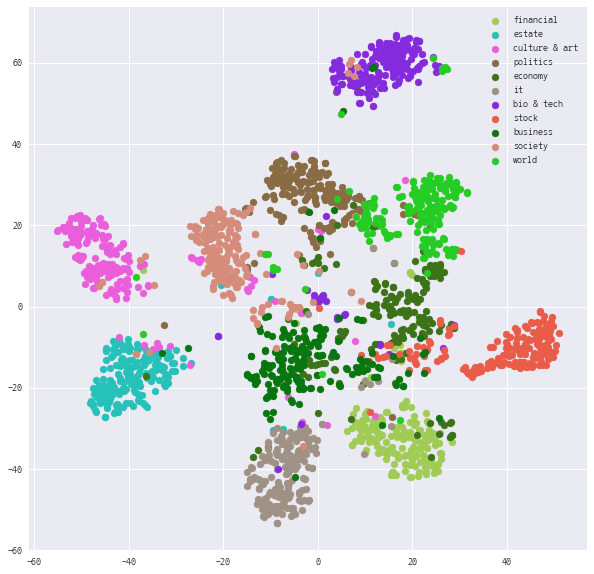

In [27]:
X =dbow.infer_vectors_with_Doc2Vec(test_token_for_display_dm, alpha = 0.1)

tsne= TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
scatter_df = pd.DataFrame(X_tsne,
                          index = test_tag_for_display_dm,
                          columns = ['x','y'])

plt.figure(figsize = (10, 10))

for i,section in enumerate(set(test_df['Section'])):
    temp_df = scatter_df[scatter_df.index == section]
    plt.scatter(temp_df['x'].values, temp_df['y'].values, label = section, c = np.random.rand(3,))

plt.legend(loc = 'best')
plt.savefig('추정된 벡터 분포 t-sne ver')

## **Doc2Vec train** 

In [19]:
'''nlp.train_Doc2Vec_model(train_df['Token'],
                        train_df['Section'],
                        n_epochs = 10)'''

"nlp.train_Doc2Vec_model(train_df['Token'],\n                        train_df['Section'],\n                        n_epochs = 10)"

## **Doc2Vec 학습결과 확인**

In [18]:
dm.Doc2Vec_model.most_similar('트럼프')

[('도널드', 0.964468240737915),
 ('와중', 0.9554681777954102),
 ('공세', 0.9504309296607971),
 ('집권', 0.949384331703186),
 ('휴전', 0.9464839696884155),
 ('백악관', 0.9445333480834961),
 ('불씨', 0.9431270360946655),
 ('반감', 0.9398562908172607),
 ('강경', 0.9397679567337036),
 ('재선', 0.9364628791809082)]

In [19]:
dm.Doc2Vec_model.most_similar('AI')

[('지능', 0.9799972176551819),
 ('인공', 0.9666788578033447),
 ('최신', 0.9551004767417908),
 ('전송속도', 0.9482595920562744),
 ('소프트웨어', 0.9425548315048218),
 ('최적화', 0.93921959400177),
 ('OS', 0.9325710535049438),
 ('기기', 0.9321522116661072),
 ('머신', 0.9316468238830566),
 ('러닝', 0.929084300994873)]

###  DBOW 모델은 단어간의 cosine similarity를 학습하지 않음

In [20]:
dbow.Doc2Vec_model.most_similar('트럼프')

[('퀘벡', 0.46451127529144287),
 ('승람', 0.4364490211009979),
 ('안락사', 0.4097716510295868),
 ('루니툰', 0.40378937125205994),
 ('내어주게', 0.4006562829017639),
 ('왜관', 0.39001941680908203),
 ('있나요', 0.38877278566360474),
 ('다가왔지만', 0.387831449508667),
 ('브레데', 0.3868614435195923),
 ('들어주었을', 0.38505056500434875)]

# **Data setting**

In [18]:
# 한 label마다 학습할 단어의 수
train_batch_size = 3000
test_batch_size = 200

X_train, y_train = nlp.oversample_batch(train_df['Token'], train_df['Section'], train_batch_size)
X_test, y_test =  nlp.undersample_batch(test_df['Token'],test_df['Section'], test_batch_size)

# 벡터화
X_train_dm = dm.infer_vectors_with_Doc2Vec(X_train, alpha = 0.05, steps = 50)
X_test_dm = dm.infer_vectors_with_Doc2Vec(X_test, alpha = 0.05, steps = 50)

In [21]:
X_train_dbow = dbow.infer_vectors_with_Doc2Vec(X_train, alpha = 0.05, steps = 50)
X_test_dbow = dbow.infer_vectors_with_Doc2Vec(X_test, alpha = 0.05, steps = 50)

# <br>


# **DM Only**

# **Logistic Regression**

In [ ]:
from sklearn.metrics import confusion_matrix

In [22]:
clf = LogisticRegression(solver = 'sag',
                         multi_class = 'multinomial')


clf.fit(X_train_dm, y_train)
y_pred = clf.predict(X_test_dm)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.9116022099447514


## **Linear SVM**

In [33]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline


In [37]:
clf = LinearSVC()

clf.fit(X_train_dm, y_train)
y_pred = clf.predict(X_test_dm)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.9161225514816675


## <br>


## **XGBoost**

In [24]:
from xgboost import XGBClassifier

In [25]:
estimator = XGBClassifier(n_estimators=1000, max_depth=2, learning_rate=0.5, nthread=7)

In [29]:
X_train_dm = np.array(X_train_dm)
X_test_dm = np.array(X_test_dm)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
estimator.fit(X_train_dm, y_train)
y_pred = estimator.predict(X_test_dm)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.9020592667001507


# **DM-DBOW Concat**

# **Logistic Regression**

In [77]:
X_train_dm = np.array(X_train_dm)
X_train_dbow = np.array(X_train_dbow)

X_test_dm = np.array(X_test_dm)
X_test_dbow = np.array(X_test_dbow)

In [68]:
X_train = np.concatenate([X_train_dm, X_train_dbow], axis = 1)
X_test = np.concatenate([X_test_dm, X_test_dbow], axis = 1)

In [70]:
clf = LogisticRegression(solver = 'sag',
                         multi_class = 'multinomial')


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.850828729281768


# **DM-DBOW sum**

# **Logistic Regression**

In [78]:
X_train = X_train_dm + X_train_dbow
X_test = X_test_dm + X_test_dbow

In [79]:
print(X_train.shape, X_test.shape)

(11000, 100) (1991, 100)


In [80]:
clf = LogisticRegression(solver = 'sag',
                         multi_class = 'multinomial')


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.8513309894525364


<br>


# 테스트

In [71]:
k = 700
print(test_df['Section'].iloc[k])
' '.join(test_df['Token'].iloc[k])

economy


'지난주 비공개 회의 EU 한발 양보 협상 진전 정상 회의 개최 발표 영국 유력 기업인 여명 최종 결정 다시 국민투표 맡겨야 박대 특파원 브렉 시트 협상 최대 쟁점 하나 아일랜드 국경 문제 유럽연합 일부 양보 합의 걸음 다가갔다는 보도 나왔다 영국 일간 더타임스 일요판 선데이타임스 별다른 미래관 합의 경우 영국 전체 당분간 EU 관세동맹 두는 방안 EU 수용 영국 일부인 북아일랜드 EU 회원 아일랜드 하드 보더 안전 장치 이슈 브렉 시트 협상 합의 걸림 돌이 왔다 앞서 영국 EU 브렉 시트 전환 기간 합의 아일랜드 국경 문제 영국 별다른 대안 제시 경우 북아일랜드 EU 관세동맹 두는 안전 치안 잠정 합의 리사 메이 영국 총리 그러나 방안 영국 영토 통합 저해 영국 전체 당분간 EU 관세동맹 두는 방안 다시 제안 지난달 벨기에 브뤼셀 열린 EU 정상 회의 영국 EU 문제 이견 좁히지 브렉 시트 협상 합의 이르지 선데이타임스 영국 EU 고위 관료 인용 영국 전체 당분간 EU 관세동맹 잔류 안전 장치 방안 EU 받아들이기로 보도 방안 영국 영원히 EU 관세동맹 남겨 영국 유럽 회의론자 지적 반영 출구 조항 넣기 신문 했다한 EU 관계자 지난주 런던 열린 비공개 회의 아일랜드 국경 문제 EU 양보 있었다고 측은 EU 캐나다 자유무역 협정 모델 비슷한 수준 자유무역 가능한 미래 경제 파트너 논의 진행 전해졌다 영국 정부 브렉 시트 협상 충분한 진전 이뤄져야만 EU 내지 특별 정상 회의 개최 방안 발표 기대하고 한편 선데이타임스 영국 주요 기업인 여명 브렉 시트 국민투표 실시 요구 서한 서명 보도 했다전 스탠다드차타드 은행 회장 데이비스 BT 회장 마이크 레이크 유력 기업인 우리 지금 눈가리개 또는 파괴 하드 브렉 시트 가능성 있다면서 간의 불확실 투자가 감소 했는데 추가 투자 침체 시킬 경고 했다이어 기업 노동자 모두 나쁜 일이 지적 마지막 선택 다시 국민투표 결정 돼야 주장'

In [69]:
clf.predict(dm.infer_vectors_with_Doc2Vec([test_df['Token'].iloc[k]]))[0]

'economy'

# 분류 결과

In [39]:
result_df = pd.DataFrame(confusion_matrix(y_test, y_pred) ,
                         index = sorted(train_df['Section'].unique()),
                         columns = sorted(train_df['Section'].unique()))

In [45]:
(result_df/result_df.sum(axis=1)).apply(lambda x: round(x*100,1))

,bio & tech,business,culture & art,economy,estate,financial,it,politics,society,stock,world
bio & tech,89.5,1.1,0.6,0.0,0.0,0.0,2.8,1.7,1.7,1.7,1.1
business,1.7,90.6,0.6,2.2,0.6,1.7,0.0,0.6,2.2,0.0,0.0
culture & art,0.6,1.7,82.9,0.6,4.4,0.6,0.0,1.7,7.2,0.0,0.6
economy,0.6,2.8,0.0,90.1,0.6,2.8,1.7,0.6,1.1,0.0,0.0
estate,0.0,1.1,0.0,1.7,93.4,0.0,0.6,0.6,2.8,0.0,0.0
financial,0.0,0.0,0.0,3.3,0.0,95.6,0.0,0.0,0.0,0.6,0.6
it,0.6,3.3,0.0,1.1,0.0,0.6,93.4,0.0,1.1,0.0,0.0
politics,0.6,0.6,0.0,1.1,0.0,0.6,0.6,89.0,2.8,0.0,5.0
society,2.2,0.0,1.7,0.6,1.7,1.1,0.6,1.1,90.1,0.0,1.1
stock,0.0,3.3,0.0,2.8,0.6,0.6,0.0,0.0,0.0,92.3,0.6


In [23]:
result_df.sum(axis = 0)

bio & tech       180
business         198
culture & art    159
economy          187
estate           182
financial        185
it               178
politics         179
society          185
stock            174
world            184
dtype: int64

<br> 


# 왜 그럴까?

# 각 카테고리 별, 토큰 길이의 평균은?

In [43]:
train_df.groupby('Section')['Num of Tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
Section,,,,,,,,
bio & tech,1739.0,208.407706,137.070908,31.0,127.0,179.0,248.00,1946.0
business,4863.0,168.279457,111.049610,31.0,100.0,143.0,207.50,1744.0
culture & art,4102.0,203.309118,212.222970,31.0,93.0,145.0,257.00,3734.0
economy,2608.0,180.457822,123.417534,31.0,89.0,149.5,241.25,1310.0
estate,3932.0,195.627416,120.098839,32.0,114.0,161.0,243.25,949.0
financial,746.0,146.214477,105.434707,32.0,77.0,114.0,178.75,978.0
it,1742.0,181.376579,122.433175,33.0,99.0,151.5,227.00,1133.0
politics,3775.0,203.313642,121.083304,32.0,115.5,171.0,265.00,1445.0
society,3356.0,163.016091,109.029483,31.0,89.0,133.0,208.00,1793.0


# 길이가 짧은 기사들은 하나로 몰아서 분류해버리는 경향이 있다


In [44]:
from collections import OrderedDict

section_ls = train_df['Section'].unique()

store_dict = OrderedDict(\
                         {'Token의 수 n개 이상' : [],
                          'Token의 수 n개 이하' : []})

for section in section_ls:
    store_dict[section] = []


## token의 수 50이상 100 이하

### 길이가 짧으면 증권, 사회 기사는 매우 잘 분류하지만, 정치, IT과학, 국제 기사는 잘 분류하지 못한다.

In [45]:
lower_limit = 50
upper_limit = 100

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


stock 카테고리의 분류 정확도는 92.00% 
world 카테고리의 분류 정확도는 78.00% 
estate 카테고리의 분류 정확도는 85.00% 
business 카테고리의 분류 정확도는 83.00% 
politics 카테고리의 분류 정확도는 84.00% 
society 카테고리의 분류 정확도는 86.00% 
culture & art 카테고리의 분류 정확도는 84.00% 
it 카테고리의 분류 정확도는 94.00% 
bio & tech 카테고리의 분류 정확도는 81.25% 
economy 카테고리의 분류 정확도는 80.00% 
financial 카테고리의 분류 정확도는 94.37% 


## token의 수 100개 이상, 300개 이하

### 길이가 길어지면 경제, 사회 기사의 정확도는 떨어지지만, 반대로 부동산, 정치, IT과학 기사의 정확도가 급상승...

In [46]:
lower_limit = 100
upper_limit = 300

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


stock 카테고리의 분류 정확도는 95.00% 
world 카테고리의 분류 정확도는 89.00% 
estate 카테고리의 분류 정확도는 93.00% 
business 카테고리의 분류 정확도는 94.00% 
politics 카테고리의 분류 정확도는 86.00% 
society 카테고리의 분류 정확도는 90.00% 
culture & art 카테고리의 분류 정확도는 76.00% 
it 카테고리의 분류 정확도는 87.00% 
bio & tech 카테고리의 분류 정확도는 88.00% 
economy 카테고리의 분류 정확도는 84.00% 
financial 카테고리의 분류 정확도는 97.00% 


## token의 수 300개 이상, 500 이하

In [47]:
lower_limit = 300
upper_limit = 500

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


stock 카테고리의 분류 정확도는 94.00% 
world 카테고리의 분류 정확도는 89.00% 
estate 카테고리의 분류 정확도는 95.00% 
business 카테고리의 분류 정확도는 92.00% 
politics 카테고리의 분류 정확도는 92.00% 
society 카테고리의 분류 정확도는 90.00% 
culture & art 카테고리의 분류 정확도는 71.00% 
it 카테고리의 분류 정확도는 91.00% 
bio & tech 카테고리의 분류 정확도는 87.00% 
economy 카테고리의 분류 정확도는 89.00% 
financial 카테고리의 분류 정확도는 98.00% 


## token의 수 500개 초과

In [48]:
lower_limit = 500
upper_limit = 10000

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


stock 카테고리의 분류 정확도는 92.00% 
world 카테고리의 분류 정확도는 91.00% 
estate 카테고리의 분류 정확도는 91.00% 
business 카테고리의 분류 정확도는 91.00% 
politics 카테고리의 분류 정확도는 89.00% 
society 카테고리의 분류 정확도는 91.00% 
culture & art 카테고리의 분류 정확도는 72.00% 
it 카테고리의 분류 정확도는 90.00% 
bio & tech 카테고리의 분류 정확도는 88.00% 
economy 카테고리의 분류 정확도는 88.00% 
financial 카테고리의 분류 정확도는 97.00% 


In [49]:
pd.DataFrame(store_dict)

,Token의 수 n개 이하,Token의 수 n개 이상,stock,world,estate,business,politics,society,culture & art,it,bio & tech,economy,financial
0,100,50,92.0 %,78.0 %,85.0 %,83.0 %,84.0 %,86.0 %,84.0 %,94.0 %,81.25 %,80.0 %,94.37 %
1,300,100,95.0 %,89.0 %,93.0 %,94.0 %,86.0 %,90.0 %,76.0 %,87.0 %,88.0 %,84.0 %,97.0 %
2,500,300,94.0 %,89.0 %,95.0 %,92.0 %,92.0 %,90.0 %,71.0 %,91.0 %,87.0 %,89.0 %,98.0 %
3,10000,500,92.0 %,91.0 %,91.0 %,91.0 %,89.0 %,91.0 %,72.0 %,90.0 %,88.0 %,88.0 %,97.0 %


# **Decision Tree**

Decision Tree 모델은 feature들이 각각 의미있는 변수들이면서, 독립적으로 사용될 수 있을 때 유용한 방법이다.


각 변수별로 적절한 기준선을 찾아 공간을 나누기 때문.

따라서 Doc2Vec과 같이 좌표평면상에서 벡터의 위치가 아무런 의미가 없는 경우, 학습 효과가 현저하게 떨어진다.

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [59]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.8206931190356604


<br>



# **RandomForestClassifier**

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
clf = RandomForestClassifier(n_estimators=100,  n_jobs = -1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
    
print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.8955298844801607


<br>



# **Neural Net**

In [62]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

## **Data Preprocessing**

In [63]:
X_train_nn = np.array(X_train).astype('float32')
y_train_nn = pd.get_dummies(y_train).values.astype('float32')


X_test_nn = np.array(X_test).astype('float32')
y_test_nn = pd.get_dummies(y_test).values.astype('float32')

In [64]:
print(X_train_nn.shape, y_train_nn.shape, X_test_nn.shape, y_test_nn.shape)

(33000, 100) (33000, 11) (1991, 100) (1991, 11)


## **Build Layers**

In [67]:
n_class = y_test_nn.shape[1]

In [68]:
# reset graphs
tf.reset_default_graph() 

# mini-batches
batch_size = X_train_nn.shape[0] // 5
dataset = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn))
dataset = dataset.batch(batch_size)

# building placeholder
X = tf.placeholder(tf.float32, shape = [None, nlp.Doc2Vec_model.vector_size])
Y = tf.placeholder(tf.float32, shape = [None, n_class])
keep_prob = tf.placeholder(tf.float32)

# building layers
n_neuron = 100

W1 = tf.get_variable('W1', shape = ([nlp.Doc2Vec_model.vector_size, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable('W2', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable('W3', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable('W4', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W5 = tf.get_variable('W5', shape = ([n_neuron, n_class]), initializer = tf.contrib.layers.xavier_initializer())

b1 = tf.Variable(tf.random_normal([n_neuron]))
b2 = tf.Variable(tf.random_normal([n_neuron]))
b3 = tf.Variable(tf.random_normal([n_neuron]))
b4 = tf.Variable(tf.random_normal([n_neuron]))
b5 = tf.Variable(tf.random_normal([n_class]))

L1 = tf.nn.relu(tf.matmul(X,W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob = keep_prob)

L2 = tf.nn.relu(tf.matmul(L1,W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob = keep_prob)

L3 = tf.nn.relu(tf.matmul(L2,W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob = keep_prob)

L4 = tf.nn.relu(tf.matmul(L3,W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob = keep_prob)

logit = tf.matmul(L4,W5) + b5
hypothesis = tf.nn.softmax(tf.matmul(L4,W5) + b5)


# cost : cross - entropy cost 
lamb = 0.0001
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y)) + lamb * tf.reduce_sum(tf.square(W5))

# optimize
learning_rate = 0.0001
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# prediction
prediction = tf.argmax(hypothesis,1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), prediction), dtype= tf.float32))



# restore results
train_cost_list = []
train_acc_list = []

test_cost_list = []
test_acc_list = []


# **Run**

### **mini-batch**

In [ ]:
# train_dict = {X: X_train, Y: y_train}
test_dict = {X: X_test_nn, Y: y_test_nn, keep_prob : 1}

training_epochs = 1500

iterator = dataset.make_initializable_iterator()
f, l = iterator.get_next()

# launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    
    for epoch in range(training_epochs):
        # iterator initialize
        sess.run(iterator.initializer)
        avg_cost = 0

        while True:
            # mini-batch
            try:
                batch_x,  batch_y = sess.run([f, l])
                feed_dict = {X : batch_x, Y: batch_y, keep_prob : 0.5}
                
                c, _ = sess.run([cost, train], feed_dict = feed_dict)
                avg_cost += c
            
            except tf.errors.OutOfRangeError:
                    break
        
        acc, _, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
        
        train_cost_list.append(avg_cost)
        test_cost_list.append(test_cost)
            
        if (epoch+1) % (100) == 0 :
            
            test_acc_list.append(acc)
            
            print('Epoch : %s'%(epoch+1), 'cost :',test_cost)
            print('Accuracy :', acc)
            
        
    
    acc, y_pred, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
    

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(train_cost_list, label = 'train_cost')
plt.plot(test_cost_list, label = 'test_cost')
plt.legend(loc = 'best')